In [1]:
from qiskit import QuantumCircuit

from qiskit_ionq import IonQProvider
# import gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
from qiskit import Aer, execute, assemble

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ionq simulator info

sns.set_style("whitegrid")

In [2]:
def equatorial_prep(qc, phi):
    qc.append(GPI2Gate(1/4), [0])
    qc.append(GPIGate(phi/(4*np.pi)),[0])
    return qc

In [3]:
def equatorial_measurement_prep(qc, phi):
    qc.append(GPIGate(phi/(4*np.pi)), [0])
    qc.append(GPI2Gate(-1/4), [0])
    
    qc.append(GPIGate(phi/(4*np.pi)), [1])
    qc.append(GPI2Gate(-1/4), [1])
    
    qc.append(GPIGate(phi/(4*np.pi)), [2])
    qc.append(GPI2Gate(-1/4), [2])
    
    return qc

In [4]:
def ionq_clone(qc, theta_2):
    '''
    This function constructs the cloning circuit in IonQ Native Gates.

    Parameters:
    --------------
    qc - Quantum circuit.
    theta_2 - float in [-pi/2, pi/2]. 

    Returns:
    --------------
    qc - Quantum circuit.
    
    '''
        
    #Eve Prep

    qc.append(GPIGate(1/4), [1])
    
    qc.append(MSGate(0,0), [1,2])
    
    qc.append(GPIGate(-1/8), [1])
    #qc.append(GPIGate(1/8), [1])
    
    qc.append(GPIGate((-np.pi/4 - theta_2)/(2 * np.pi)), [2])
    #qc.append(GPIGate((np.pi/4 - theta_2)/(2 * np.pi)), [2])
    
    qc.append(MSGate(0,0), [2,1])
    
    qc.append(GPI2Gate(-1/4),[2])
     
    
    qc.append(GPIGate(1/8),[1])
    qc.append(GPIGate(0), [1])
    qc.append(GPI2Gate(1/4), [1])
    qc.append(GPIGate(theta_2/(2*np.pi)), [1])
    qc.append(GPI2Gate(1/4), [1])
    qc.append(GPIGate(1/8), [1])
    
    #Eve Clone
    
    qc.append(GPI2Gate(1/4), [0])
    
    qc.append(MSGate(0,0), [0,1])
    
    qc.append(MSGate(0,0), [0,2])
    
    qc.append(GPI2Gate(1/4), [0])
    
    qc.append(GPIGate(-1/8), [2])
    qc.append(GPIGate(-1/8), [1])
    #qc.append(GPIGate(1/8), [2])
    #qc.append(GPIGate(1/8), [1])
    
    qc.append(MSGate(0,0), [1,0])
    
    qc.append(GPI2Gate(-1/4), [1])
    
    qc.append(MSGate(0,0), [2,0])
    
    qc.append(GPI2Gate(-1/4), [2])

    
    return qc


In [5]:
def equatorial_cloner(theta2, phi):
    qc = QuantumCircuit(3,3)
    
    qc = equatorial_prep(qc, phi)
    qc.barrier()
    
    qc = ionq_clone(qc, theta2)
    qc.barrier()
    
    qc = equatorial_measurement_prep(qc, phi)
    qc.barrier
    
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)
    
    return qc

In [6]:
def fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval, shots):
    
    if bitval == 1:
        B = (out001 + out011 + out101 + out111)/shots
        E = (out010 + out011 + out110 + out111)/shots
        A = (out100 + out101 + out110 + out111)/shots
        
    if bitval == 0:
        B = (out010 + out000 + out110 + out100)/shots
        E = (out001 + out000 + out101 + out100)/shots
        A = (out000 + out001 + out010 + out011)/shots
        
    return B,E,A 

In [7]:
def phase_covariance_ionq(theta2, phi, shots):
        
    qc = equatorial_cloner(theta2, phi)
    
    #shots = 1024 # number of samples used for statistics
    #sim = Aer.get_backend('qasm_simulator')
    provider = IonQProvider("RmK0yNkCDPmoxCH12uQ4U67lpu9kFgik")
    native_simulator = provider.get_backend("ionq_simulator", gateset="native")
    job = native_simulator.run(qc, shots = shots)
        
    out000 = job.result().get_counts().get("000")
    out001 = job.result().get_counts().get("001")
    out010 = job.result().get_counts().get("010")
    out011 = job.result().get_counts().get("011")
    out100 = job.result().get_counts().get("100")
    out101 = job.result().get_counts().get("101")
    out110 = job.result().get_counts().get("110")
    out111 = job.result().get_counts().get("111")

    if out000 == None:
        out000 = 0
    if out001 == None:
        out001 = 0
    if out010 == None:
        out010 = 0
    if out011 == None:
        out011 = 0
        
    if out100 == None:
        out100 = 0
    if out101 == None:
        out101 = 0
    if out110 == None:
        out110 = 0
    if out111 == None:
        out111 = 0
        
    B,E,A = fidelities(out000, out001, out010, out011, out100, out101, out110, out111, 0, shots)
    
    return B,E,A

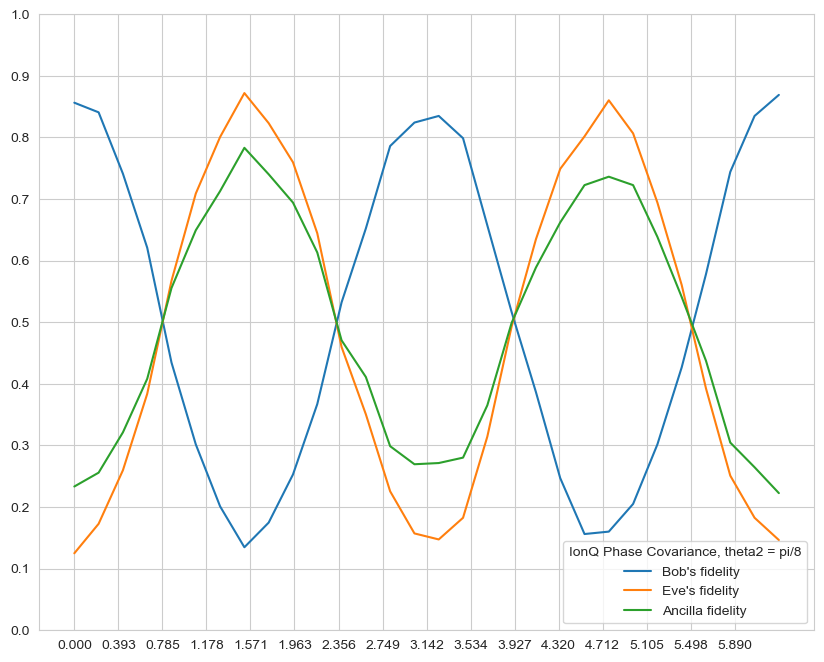

In [8]:
Phi = np.linspace(0, 2*np.pi, 30)

B = []
E = []
A = []

for k in range(len(Phi)):
    b, e, a = phase_covariance_ionq(np.pi/8, Phi[k], 1024)
    B.append(b)
    E.append(e)
    A.append(a)
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(Phi, B, label = "Bob's fidelity")
plt.plot(Phi, E, label = "Eve's fidelity")
plt.plot(Phi, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(0, 2*np.pi, step = np.pi/8))
plt.legend(title="IonQ Phase Covariance, theta2 = pi/8")
plt.show()

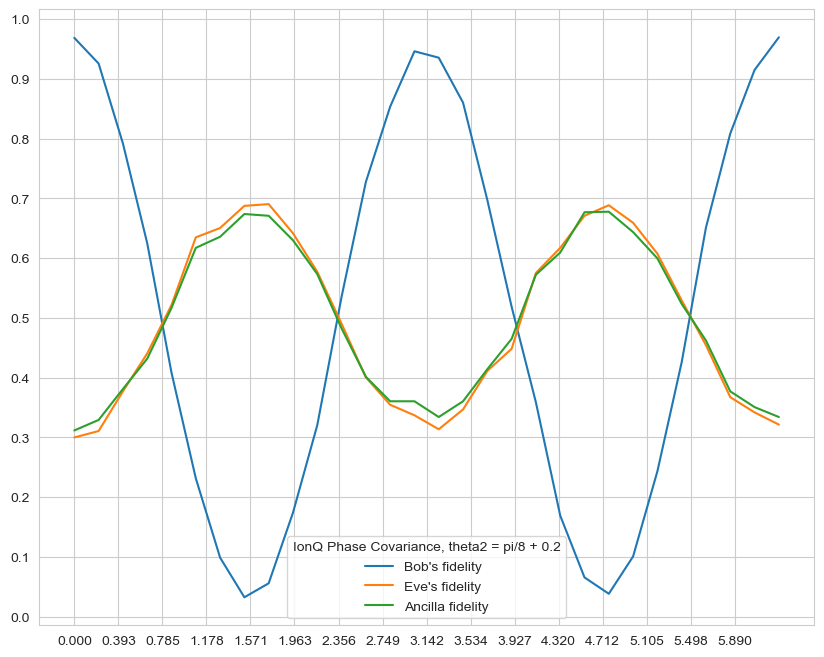

In [9]:
Phi = np.linspace(0, 2*np.pi, 30)

B = []
E = []
A = []

for k in range(len(Phi)):
    b, e, a = phase_covariance_ionq(np.pi/8 + 0.2, Phi[k], 1024)
    B.append(b)
    E.append(e)
    A.append(a)
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(Phi, B, label = "Bob's fidelity")
plt.plot(Phi, E, label = "Eve's fidelity")
plt.plot(Phi, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(0, 2*np.pi, step = np.pi/8))
plt.legend(title="IonQ Phase Covariance, theta2 = pi/8 + 0.2")
plt.show()
